# Тестовое задание Стажер-Исследователь (урбанистика)

## Подготовка

In [1]:
import copy
import io
import re

from typing import Optional

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from shapely.geometry import Point, Polygon
import shapely


Загрузим пример

In [2]:
geojson_data = gpd.read_file('input/example.geojson')
geojson_data

,name,restriction,geometry
0,Зона застройки,None,"POLYGON ((37.6173 55.7558, 37.6179 55.7565, 37..."
1,Лесная зона,no_build,"POLYGON ((37.618 55.756, 37.6185 55.7565, 37.6..."
2,Дорога,no_build,"LINESTRING (37.6175 55.7555, 37.6185 55.7555)"


Создадим функцию для визуализации геоданных (visualize_geo) и функцию для формирования их стиля отображения (geojson_style)

In [3]:
def geojson_style(
                color: dict[str, str] = None, 
                fill_color: dict[str, str] = None,
                default_color: str = 'black', 
                default_fill_color: str = 'white', 
                fill_color_as_primary: bool = True) -> callable:
    """
    Функция для задания стиля отображения в функции visualize_geo
    
    Параметры:
    color - словарь цветов границ для каждого типа объекта
    fill_color - словарь цветов заливки для каждого типа объекта
    default_color - цвет границ по умолчанию
    default_fill_color - цвет заливки по умолчанию
    fill_color_as_primary - использовать цвет заливки как основной
    """
    # Инициализация словаря цветов границ
    if color is None:
        color = dict()

    # Инициализация словаря цветов заливки
    if fill_color is None:
        if fill_color_as_primary:
            fill_color = copy.deepcopy(color)
        else:
            fill_color = dict()

    # Если цвет заливки основной, копируем его в цвета границ
    elif fill_color_as_primary:
        for key in fill_color.keys():
            color[key] = fill_color[key]
    
    # Создаем функцию стиля, которая будет применяться к каждому объекту
    style_function=lambda x: {
        'color': color.get(x['properties'].get('name'), default_color),
        'fillColor': fill_color.get(x['properties'].get('name'), default_fill_color),
    }
    
    return style_function
    

def visualize_geo(
                    geojson_data: gpd.GeoDataFrame, 
                    geojson_style: Optional[callable] = None, 
                    map_center: Optional[tuple[float, float]] = None, 
                    legend_groups: Optional[dict[str, str]] = None) -> plt.Figure:   
    """
    Функция для визуализации GeoDataFrame данных
    
    Параметры:
    geojson_data - данные в формате GeoDataFrame
    geojson_style - функция стиля для отображения объектов
    map_center - центр карты
    legend_groups - группировка элементов легенды
    """
    # Создаем фигуру и оси для отрисовки
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Список для хранения элементов легенды
    legend_elements = []
    
    # Если задан стиль, применяем его к каждому объекту
    if geojson_style:
        # Получаем уникальные имена объектов
        unique_names = geojson_data['name'].unique()
        processed_names = set()
        
        # Отрисовываем каждый объект
        for idx, row in geojson_data.iterrows():
            style = geojson_style({"properties": {"name": row.get('name')}})
            gpd.GeoDataFrame(geometry=[row.geometry]).plot(
                ax=ax,
                color=style['fillColor'],
                edgecolor=style['color'],
                alpha=0.5
            )
            
            # Добавляем элемент в легенду, если он еще не добавлен
            if row['name'] in unique_names and row['name'] not in processed_names:
                legend_label = row['name']
                # Если заданы группы легенды, группируем элементы
                if legend_groups:
                    for new_name, pattern in legend_groups.items():
                        if re.search(pattern, row['name']):
                            legend_label = new_name
                            break
                
                # Создаем элемент легенды
                legend_elements.append(
                    Patch(facecolor=style['fillColor'],
                          edgecolor=style['color'],
                          alpha=0.5,
                          label=legend_label)
                )
                processed_names.add(row['name'])
    else:
        # Если стиль не задан, отображаем данные как есть
        geojson_data.plot(ax=ax)
    
    # Добавляем легенду, если есть элементы
    if legend_elements:
        # Удаляем дубликаты в легенде
        unique_legend = []
        seen_labels = set()
        for element in legend_elements:
            if element.get_label() not in seen_labels:
                unique_legend.append(element)
                seen_labels.add(element.get_label())
        ax.legend(handles=unique_legend, loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    ax.set_aspect('equal') # Устанавливаем равные масштабы по осям
    ax.set_axis_off() # Скрываем оси
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Настраиваем компоновку с учетом легенды
    plt.close(fig) # Закрываем фигуру для предотвращения отображения
    
    return fig

Визуализируем данние примера

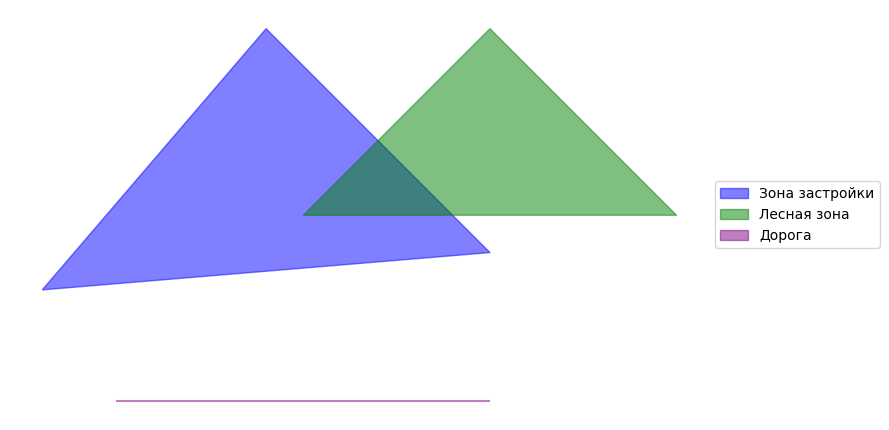

In [4]:
# Создаем визуализацию результатов размещения объектов
m = visualize_geo(
    # Передаем датафрейм с геометрическими объектами
    geojson_data=geojson_data,
    # Настраиваем стили отображения для разных типов объектов
    geojson_style=geojson_style(
        color={
            'Зона застройки': 'blue',
            'Лесная зона': 'green',
            'Дорога': 'purple'
        },
    )
)

# Отображаем результат
m

Выведем зону постройки в переменную

Зона застройки:


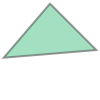

In [5]:
# Выведем зону постройки
build_area_name = 'Зона застройки'
build_area_geometry = geojson_data.loc[geojson_data.name == build_area_name].iloc[0]['geometry']
print(f'{build_area_name}:')
build_area_geometry

Выведем список зон с запетом строительства

In [6]:
# Зоны с запретом строительства
geojson_data.loc[geojson_data.restriction == 'no_build']

,name,restriction,geometry
1,Лесная зона,no_build,"POLYGON ((37.618 55.756, 37.6185 55.7565, 37.6..."
2,Дорога,no_build,"LINESTRING (37.6175 55.7555, 37.6185 55.7555)"


Построим зону, где разрешено строительство с учетом ограничений. (Вычтем из зоны строительства зоны с запретом строительства)

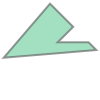

In [7]:
# Построим зону, где разрешено строительство с учетом ограничений
free_build_zone = geojson_data.loc[0, 'geometry']
for no_build in geojson_data.loc[geojson_data.restriction == 'no_build']['geometry'].iloc:
    free_build_zone = free_build_zone - no_build

free_build_zone

Напишием функцию распределения объектов внутри зоны (для резмещения зданий внутри зоны строительства). 

Функция будет размещать объекты по сетке при выполнении необходимых устовий (объект должен находиться внутри заданной зоны, объекты не должны пересекаться и т.д.). Предусмотрен поворот объекта, минимальное расстояние между объектами, ограничения по площади заполнения и максимальному количеству объектов (останавливают алгоритм), 

На вход подаются параметры:
1. `fill_area`: **область, в которой нужно разместить объекты**
2. `filling_object_instance`: **образец объекта, который нужно размещать**
3. `step`: шаг сетки (расстояние между точками размещения)
4. `buffer`: минимальное расстояние между объектами (буферная зона)
5. `rotate_step`: шаг поворота объекта в градусах (если None, поворот не выполняется)
6. `max_objects_number`: максимальное количество размещаемых объектов
7. `max_filled_area_share`: максимальная доля площади заполнения

Работа алгоритма:
- Подготовка :
  - Если шаг поворота не задан, устанавливается 361° (фактически без поворотов)
  - Получаются границы области заполнения и размещаемого объекта
  - Объект перемещается к началу координат для корректности манипуляций
- Размещение объектов :
  - Создается влоденный цикл по координатам X и Y с заданным шагом (преребор точек сетки). Циклы начинаюся от минимальных знаачений координат заполняемого объекта (с запасом на размеры размещаемого объекта) и заканчиваются на каксимальных знаачениях координат заполняемого объекта (также с запасом на размеры размещаемого объекта)
  - В каждой точке сетки производится попытка размещения объекта под разными углами поворота.
  - При попытке размещении:
    - Добавляется буферная зона вокруг объекта (если задан buffer)
    - Проверяется достижение максимального количества объектов
    - Проверяется достижение максимальной площади заполнения
    - Проверяется, помещается ли объект в область заполнения (с учетом буферной зоны)
    - Проверяется пересечение с уже размещенными объектами (с учетом буферной зоны)
    - При выполнении всех условий оригинальный объект (без буыерной зоны) добавляется в список размещенных объектов
- Результат: Возвращается GeoDataFrame с размещенными объектами

In [8]:
def grid_fill_area(
                fill_area: shapely.geometry.base.BaseGeometry,
                filling_object_instance: shapely.geometry.base.BaseGeometry,
                step: float,
                buffer: float = 0,
                rotate_step: Optional[int] = None,
                max_objects_number: Optional[int] = None,
                max_filled_area_share: Optional[float] = None) -> gpd.GeoDataFrame:
    """
    Функция для заполнения области геометрическими объектами по сетке
    
    Параметры:
    fill_area - область для заполнения
    filling_object_instance - объект для заполнения
    step - шаг сетки
    buffer - буфер между объектами
    rotate_step - шаг поворота в градусах (None - без поворота)
    max_objects_number - максимальное количество объектов (None - без ограничения)
    max_filled_area_share - максимальная доля заполненной площади (None - без ограничения)
    """

    if rotate_step is None:
        rotate_step = 361

    # Получаем границы области заполнения
    minx, miny, maxx, maxy = fill_area.bounds
    sminx, sminy, smaxx, smaxy = filling_object_instance.bounds

    # Перемещаем объект к началу координат
    filling_object_instance = shapely.affinity.translate(filling_object_instance, xoff=-min(sminx, smaxx), yoff=-min(sminy, smaxy))
    sminx, sminy, smaxx, smaxy = filling_object_instance.bounds

    # Список для хранения размещенных объектов
    placed_objects = []

    # Флаги и счетчики
    limit_reached = False
    filled_area = 0
    x = minx - smaxx
    
    # Основной цикл по сетке по X
    while (x < (maxx + smaxx)) and (not limit_reached):
        y = miny - smaxy
        # Вложенный цикл по Y
        while (y < (maxy + smaxy)) and (not limit_reached):
            # Перебор углов поворота
            for rot in range(0, 361, rotate_step):
                # Создаем повернутую и перемещенную копию объекта
                translated_shape = shapely.affinity.rotate(shapely.affinity.translate(filling_object_instance, xoff=x, yoff=y), rot, origin='center')
                # Создаем повернутую и перемещенную копию объекта с отступом от границ
                translated_shape_buffer = shapely.affinity.rotate(shapely.affinity.translate(filling_object_instance, xoff=x, yoff=y).buffer(buffer), rot, origin='center')
                
                # Проверка на достижение максимального количества объектов
                if not (max_objects_number is None):
                    if len(placed_objects) >= max_objects_number:
                        limit_reached = True

                # Проверка на достижение максимальной площади заполнения
                if not (max_filled_area_share is None):
                    if filled_area + translated_shape.area > fill_area.area * max_filled_area_share:
                        limit_reached = True

                if limit_reached:
                    break

                # Проверка возможности размещения объекта
                if fill_area.contains(translated_shape_buffer):
                    if all(not translated_shape_buffer.intersects(existing) for existing in placed_objects):
                        # Размещение объекта
                        placed_objects.append(translated_shape)
                        filled_area += translated_shape.area
            y += step
        x += step

    # Возвращаем результат в виде GeoDataFrame
    return gpd.GeoDataFrame(geometry=placed_objects)

Проведем размещение объектов на подготовленной зоне. Выведем зону, которая осталась не заполненной

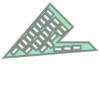

In [9]:
# Создаем экземпляр полигона с заданными координатами
filling_object_instance = Polygon([
    (100+0, 100+0), (100+0, 100+0.00005*2),
    (100+0.00005, 100+0.00005*2), (100+0.00005, 100+0),
])

# Заполняем свободную зону объектами с заданными параметрами
placed_objects = grid_fill_area(
    fill_area=free_build_zone, 
    filling_object_instance=filling_object_instance, 
    step=0.00001,  # Шаг сетки
    buffer=0.00002,  # Минимальное расстояние между объектами
    rotate_step=45,  # Шаг поворота объектов
    max_objects_number = None,  # Максимальное количество объектов (не ограничено)
    max_filled_area_share = None  # Максимальная доля заполненной площади (не ограничена)
)

# Создаем копию зоны застройки
free_build_zone_without_objects = copy.deepcopy(free_build_zone)

# Вычитаем все размещенные объекты из зоны застройки
for obj in placed_objects['geometry']:
    free_build_zone_without_objects = free_build_zone_without_objects - obj

# Зона застройки без размещенных объектов
free_build_zone_without_objects

Объединим размещенные объекты с исходными, проименуем их как строения с номером. Добавим им ограничения на застройку

In [10]:
# Добавляем названия строений на основе их индексов
placed_objects['name'] = placed_objects.index.to_frame()[0].apply(lambda n: f'Строение {n}')

# Устанавливаем тип ограничения 'no_build' для всех объектов
placed_objects['restriction'] = 'no_build'

# Объединяем исходные данные GeoJSON с размещенными объектами в единый датафрейм
result = pd.concat([geojson_data, placed_objects], ignore_index=True)

# Выводим полученный объединенный датафрейм
result

/mnt/o/ilyaDS/MindSet_test_25_03/.venv/lib/python3.11/site-packages/geopandas/array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


,name,restriction,geometry
0,Зона застройки,None,"POLYGON ((37.6173 55.7558, 37.6179 55.7565, 37..."
1,Лесная зона,no_build,"POLYGON ((37.618 55.756, 37.6185 55.7565, 37.6..."
2,Дорога,no_build,"LINESTRING (37.6175 55.7555, 37.6185 55.7555)"
3,Строение 0,no_build,"POLYGON ((37.6175 55.75591, 37.61743 55.75584,..."
4,Строение 1,no_build,"POLYGON ((37.61754 55.7559, 37.61747 55.75597,..."
5,Строение 2,no_build,"POLYGON ((37.61759 55.75595, 37.61752 55.75602..."
6,Строение 3,no_build,"POLYGON ((37.61767 55.75592, 37.6176 55.75585,..."
7,Строение 4,no_build,"POLYGON ((37.61764 55.756, 37.61757 55.75607, ..."
8,Строение 5,no_build,"POLYGON ((37.61768 55.75606, 37.61761 55.75613..."
9,Строение 6,no_build,"POLYGON ((37.61772 55.7559, 37.61765 55.75597,..."


Визуализируем результат

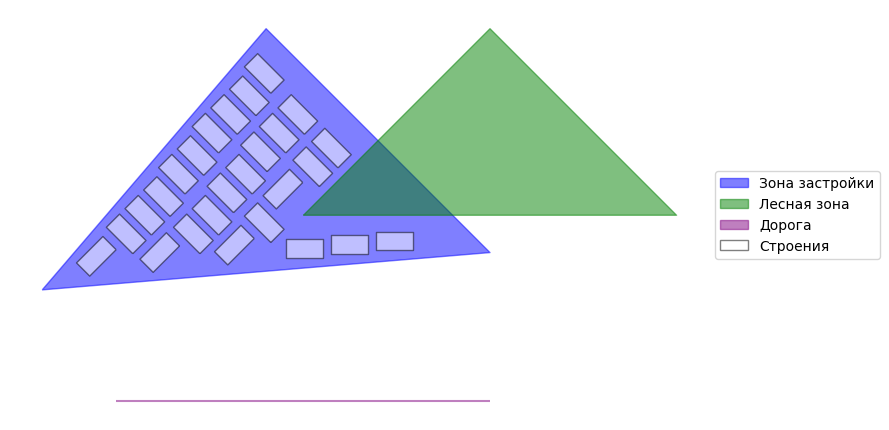

In [11]:
# Создаем визуализацию результатов размещения объектов
m = visualize_geo(
    # Передаем датафрейм с геометрическими объектами
    geojson_data=result,
    # Задаем группировку для легенды - все строения будут объединены под одним названием
    legend_groups={
        'Строения': r'Строение \d*'
    },
    # Настраиваем стили отображения для разных типов объектов
    geojson_style=geojson_style(
        color={
            'Зона застройки': 'blue',
            'Лесная зона': 'green',
            'Дорога': 'purple'
        },
    )
)

# Отображаем результат
m

Сохраним результаты

In [22]:
m.savefig('output/map.png', bbox_inches='tight')
m.savefig('output/map.svg', bbox_inches='tight')

with open('output/map.geojson', 'w') as f:
    f.write(result.to_json(indent=2))